In [298]:
import os
import sys
import datacube
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
from datacube.utils import geometry
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS
from otps import TimePoint
from otps import predict_tide
from dateutil.relativedelta import relativedelta
from collections import Counter
import warnings

sys.path.append('../10_Scripts')
import SpatialTools, DEAPlotting

# Create datacube instance
dc = datacube.Datacube(app='Tidal geomedian filmstrips')
dc_upgrade = datacube.Datacube(config='/home/561/rt1527/.ard-interoperability_tmp.conf')


def date_range(start_date, end_date, freq = '1YS'):
    
    '''
    Generates a dictionary of from-to date ranges based on a start and end date, and
    a temporal frequency (e.g. annually or six-monthly etc).
    
    Frequencies are based on Panda's date offset objects - see the following list:
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects.
    Options include annual ('1YS'), every 6 months ('6MS') etc.
    
    Outputs a dictionary with each time range named by its starting date.
    '''    

    # Convert to list of from-to dates. 
    from_dates = pd.date_range(start_date, end_date, freq=freq)[:-1].astype(str).values
    to_dates = pd.date_range(start_date, end_date, freq=freq)[1:].astype(str).values
    
    # Combine into a dictionary. Starting dates for each range are used to name output files.
    date_ranges = {a: (a, b) for (a, b) in np.dstack([from_dates, to_dates])[0]}
    
    return date_ranges


def mostcommon_utm(dc, product, query):    
    
    '''
    Takes a given query and returns the most common UTM zone for 
    observations returned for that spatial extent.
    
    '''
    
    # List of matching products
    matching_datasets = dc.find_datasets(product=product, **query)
    
    # Extract all CRSs
    crs_list = [str(i.crs) for i in matching_datasets]    
   
    # Identify most common CRS
    crs_counts = Counter(crs_list)    
    crs_mostcommon = crs_counts.most_common(1)[0][0]

    # Warn user if multiple CRSs are encountered
    if len(crs_counts.keys()) > 1:

        warnings.warn(f'Multiple UTM zones {list(crs_counts.keys())} were returned for this query.' 
                      f'Defaulting to the most common zone: {crs_mostcommon}', UserWarning)
    
    return crs_mostcommon


def tidal_tag(ds, tidepost_lat=None, tidepost_lon=None, swap_dims=False):
    
    if not tidepost_lat or not tidepost_lon:

        tidepost_lon, tidepost_lat = ds.extent.centroid.to_crs(crs=CRS('EPSG:4326')).coords[0]
        print(f'Setting tide post from dataset centroid: {tidepost_lon}, {tidepost_lat}')

    else:
        print(f'Using user-supplied tide post: {tidepost_lon}, {tidepost_lat}')

    # Use the tidal mode to compute tide heights for each observation:
    obs_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()
    obs_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in obs_datetimes]
    obs_predictedtides = predict_tide(obs_timepoints)

    # If tides cannot be successfully modeled (e.g. if the centre of the xarray dataset 
    # is located is over land), raise an exception 
    if len(obs_predictedtides) == 0:

        raise ValueError(f'Tides could not be modelled for dataset centroid located at '
                         f'{tidepost_lon}, {tidepost_lat}. This can happen if this coordinate '
                         f'occurs over land. Please manually specify a tide modelling post '
                         f'located over water using the `tidepost_lat` and `tidepost_lon` parameters.')

    else:

        # Extract tide heights
        obs_tideheights = [predictedtide.tide_m for predictedtide in obs_predictedtides]

        # Assign tide heights to the dataset as a new variable
        ds['tide_heights'] = xr.DataArray(obs_tideheights, [('time', ds.time)])

        # If swap_dims = True, make tide height the primary dimension instead of time
        if swap_dims:

            # Swap dimensions and sort by tide height
            ds = ds.swap_dims({'time': 'tide_heights'})
            ds = ds.sortby('tide_heights')     

        return ds

from scipy import stats
import pandas as pd

def change_regress(row, std_dev=3):
    
    # Extract x (time) and y (distance) values
    x = np.array([int(i[:4]) for i in row.index[1:]])
    y = row.values[1:].astype(np.float)
    
    # Remove outliers
    xy_df = np.vstack([x, y]).T
    outlier_bool = (np.abs(stats.zscore(xy_df)) < float(std_dev)).all(axis=1)
    xy_df = xy_df[outlier_bool]
        
    # Compute linear regression
    lin_reg = stats.linregress(x=xy_df[:,0], 
                               y=xy_df[:,1])
    
    # Return slope, p-values and list of outlier years excluded from regression   
    return pd.Series({'slope': np.round(lin_reg.slope, 2), 
                      'pvalue': np.round(lin_reg.pvalue, 3),
                      'outliers': str(x[~outlier_bool]).replace('[', '').replace(']', '')})


## Set spatial query

In [318]:
# # Option 1: For a set of discontinuous or unevenly sized time steps (e.g. climatic periods, before-after development).
# # Each set of dates will be exported as an individual shoreline
# study_area = 'tweed_custom'  # Name used as prefix for output files
# lat_extents = (-28.15, -28.19)   
# lon_extents = (153.51, 153.56)
# time_periods = {'elnino_1': ('1991-01-01', '1995-01-01'),
#                 'lanina_1': ('1998-02-01', '2001-01-01')}

# # Option 1: For a set of discontinuous or unevenly sized time steps (e.g. climatic periods, before-after development).
# study_area = 'adelaide_custom'  # Name used as prefix for output files
# lat_extents = (-34.88, -34.96)   
# lon_extents = (138.48, 138.52)
# time_periods = {'elnino_1': ('1990-01-01', '1991-06-01'),
#                 'lanina_1': ('1993-01-01', '1994-01-01'),
#                 'elnino_2': ('1994-01-01', '1995-01-01')}

# Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
study_area = 'adelaide'  # Name used as prefix for output files
lat_extents = (-34.755, -35.3391)   
lon_extents = (138.4194, 138.5249)
time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'cabarita'  # Name used as prefix for output files
# lat_extents = (-28.1387, -29.43)   
# lon_extents = (153.3197, 153.65)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'avoca'  # Name used as prefix for output files
# lat_extents = (-32.8168, -34.0528)   
# lon_extents = (151.0785, 151.9347)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'pilbara'  # Name used as prefix for output files
# lat_extents = ( -21.2890, -22.100)   
# lon_extents = (114.4546, 115.5185)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'pointstuart'  # Name used as prefix for output files
# lat_extents = (-12.00, -12.60)   
# lon_extents = (130.8, 132.59)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'tworocks'  # Name used as prefix for output files
# lat_extents = ( -31.4664, -31.7692)   
# lon_extents = (115.5518, 115.7623)
# time_periods = date_range('2010-01-01', '2019-01-01', freq = '1YS')


# Optional parameters
min_tide_perc = 0.5  # Minumum percentile of the observed tidal range to include (e.g. 0.5 = median tide height)
max_tide_perc = 1.0  # Maximum percentile of the observed tidal range to include (e.g. 1.0 = maximum tide height)
water_index = 'mndwi'  # Water index used to extract waterlines. Options are 'mndwi', 'ndwi', 'awei_s', 'awei_ns'
index_threshold = 0.1  # Threshold used to extract waterlines. Generally, this will be near to 0
min_vertices = 100  # Minimum size of waterlines in vertexes to extract. Larger values remove small, isolated waterlines
sensors = ['ls5', 'ls7', 'ls8']  # Landsat satellites to load (e.g. Landsat 5, 7, 8)

# Preview area
DEAPlotting.display_map(x=lon_extents, y=lat_extents, crs='EPSG:4326')

## Load satellite data

This will first attempt to extract data from the collection upgrade DEA Landsat Collection 3 data to avoid jagged resampling artefacts in the output contours. If this is not possible, it will revert to importing DEA Landsat Collection 2 data which will produce jagged contours due to nearest neighbour resampling that was originally used when the data was ingested into the datacube.

In [319]:
# If output data and figure directories doesn't exist, create them
if not os.path.isdir('output_data/{}/'.format(study_area)):
    os.makedirs('output_data/{}/'.format(study_area))

# Create a query based on lat and lon extents and all of time. This is filtered by tide
# and time periods (using `dask`) before any data is actually loaded
query = {'y': lat_extents,
         'x': lon_extents,
         'crs': 'EPSG:4326',
         'time': ('1986-01-01', '2020-01-01')}

# Output dicts to hold entire time-series for each sensor
sensor_dict = {}

# First try using collection upgrade DEA Landsat Collection 3 data to avoid jagged resampling artefacts
try:

    # Obtain output CRS by taking the most common value of matching Landsat 5 observations
    output_crs = mostcommon_utm(dc=dc_upgrade, product='ls5_ard', query=query)

    # For each sensor, dask load data and compute tide heights for each sensor
    for sensor in sensors:    

        # Return observations matching query without actually loading them using dask
        sensor_ds = dc_upgrade.load(product='{}_ard'.format(sensor), 
                                    measurements=['nbart_red', 'nbart_green', 'nbart_blue', 
                                                  'nbart_nir', 'nbart_swir_1', 'nbart_swir_2', 'fmask'],
                                    group_by='solar_day', 
                                    output_crs=output_crs,
                                    resolution=(-30, 30),
                                    gqa_iterative_mean_xy=(0, 1),  # Tolerate no more than a one pixel shift
                                    align=(15, 15),  # Fix for 15m NW offset in collection upgrade
                                    dask_chunks={'time': 1},  # Lazily load data
                                    **query)  

        # Mask data by pixel quality/fmask to remove cloud, shadow, nodata etc
        bad_quality = (sensor_ds.fmask == 0) | (sensor_ds.fmask == 2) | (sensor_ds.fmask == 3)
        sensor_ds = sensor_ds.where(~bad_quality)    

        # Append results for each sensor to a dictionary with sensor name as the key
        sensor_ds = sensor_ds.rename({'nbart_red': 'red', 'nbart_blue': 'blue', 'nbart_green': 'green', 
                                      'nbart_nir': 'nir', 'nbart_swir_1': 'swir1', 'nbart_swir_2': 'swir2'})
        
        # Append cloud filtered sensor data to dictionary
        sensor_dict[sensor] = sensor_ds
        
# If DEA Collection 3 data is not available, revert to using DEA Landsat Collection 2
except IndexError:
    
    print('Collection upgrade data (DEA Landsat Collection 3) is unavailable for this location. '
          'Reverting to DEA Landsat Collection 2 (contours will be affected by resampling artefacts)')    
  
    # For each sensor, dask load data and compute tide heights for each sensor
    for sensor in sensors:            
    
        # Return observations matching query without actually loading them using dask
        sensor_ds = dc.load(product = '{}_nbart_albers'.format(sensor), 
                         group_by = 'solar_day', 
                         measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2'],
                         dask_chunks={'time': 1},
                         **query)

        # Load PQ data matching query without actually loading them using dask
        pq_ds = dc.load(product = '{}_pq_albers'.format(sensor),
                        group_by = 'solar_day',
                        fuse_func=ga_pq_fuser, 
                        dask_chunks={'time': 1},
                        **query)
        
        # Filter to keep only observations that have matching PQ data 
        time = (sensor_ds.time - pq_ds.time).time
        sensor_ds = sensor_ds.sel(time=time)
        pq_ds = pq_ds.sel(time=time)               

        # Identify pixels with no clouds/shadows in either ACCA for Fmask
        good_quality = masking.make_mask(pq_ds.pixelquality,
                                         cloud_acca='no_cloud',
                                         cloud_shadow_acca='no_cloud_shadow',
                                         cloud_shadow_fmask='no_cloud_shadow',
                                         cloud_fmask='no_cloud',
                                         blue_saturated=False,
                                         green_saturated=False,
                                         red_saturated=False,
                                         nir_saturated=False,
                                         swir1_saturated=False,
                                         swir2_saturated=False,
                                         contiguous=True)

        # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
        sensor_ds = sensor_ds.where(good_quality)
        sensor_ds = masking.mask_invalid_data(sensor_ds)   
        
        # Append cloud filtered sensor data to dictionary
        sensor_dict[sensor] = sensor_ds

# Combine into a single xarray dataset
all_ds = xr.concat(sensor_dict.values(), dim='time')
all_ds = all_ds.sortby('time')

# Tag with tide heights and compute percentile tide heights
all_ds = tidal_tag(all_ds, tidepost_lat=None, tidepost_lon=None, swap_dims=False)
# all_ds = tidal_tag(all_ds, tidepost_lat=-29.0091, tidepost_lon=153.5889, swap_dims=False)
min_tide_thresh = all_ds.tide_heights.quantile(min_tide_perc).item()
max_tide_thresh = all_ds.tide_heights.quantile(max_tide_perc).item()

# Clip to tide range between min and max percentiles
all_ds = all_ds.sel(time=(all_ds.tide_heights > min_tide_thresh) & (all_ds.tide_heights <= max_tide_thresh))

Collection upgrade data (DEA Landsat Collection 3) is unavailable for this location. Reverting to DEA Landsat Collection 2 (contours will be affected by resampling artefacts)
Setting tide post from dataset centroid: 138.4722533170673, -35.046884223788744


## Generate median water index composites for each time period in `time_periods`

In [320]:
# Compute water indices
all_ds["ndwi"] = (all_ds.green - all_ds.nir) / (all_ds.green + all_ds.nir)
all_ds["mndwi"] = (all_ds.green - all_ds.swir1) / (all_ds.green + all_ds.swir1)
all_ds["awei_ns"] = (4 * (all_ds.green * 0.0001 - all_ds.swir1 * 0.0001) -
                    (0.25 * all_ds.nir * 0.0001 + 2.75 * all_ds.swir2 * 0.0001))
all_ds["awei_s"] = (all_ds.blue * 0.0001 + 2.5 * all_ds.green * 0.0001 - 
                    1.5 * (all_ds.nir * 0.0001 + all_ds.swir1 * 0.0001) - 0.25 * all_ds.swir2 * 0.0001)

# Create median composites for each timestep
composite_list = []

# Actually load data for the first time for each time period, and generate median water index composite
for name, time_period in time_periods.items():
    
    print(f'Generating median composites for timestep {name} (from {time_period[0]} to {time_period[1]})')
    
    # Load time period subset
    subset_ds = all_ds.sel(time=slice(time_period[0], time_period[1]))   
    
    # Compute median of water index and tide heights
    median_comp = subset_ds[['tide_heights', water_index]].compute().median(dim='time', keep_attrs=True)
    
    # Compute number of observations and min//max/standard deviation of tide heights
    median_comp['tide_m_min'] = subset_ds.tide_heights.min(dim='time', keep_attrs=True)
    median_comp['tide_m_max'] = subset_ds.tide_heights.max(dim='time', keep_attrs=True)
    median_comp['tide_m_std'] = subset_ds.tide_heights.std(dim='time', keep_attrs=True)
    median_comp['obs_n'] = len(subset_ds.time)
    
    # Export to file
    filename = f'output_data/{study_area}/{study_area}_{name}_{water_index}.tif'
    write_geotiff(filename=filename, dataset=median_comp[[water_index]])    
    
    composite_list.append(median_comp)
    
# Combine into one dataset with dimension names
composite_ds = xr.concat(composite_list, dim='timeperiod')
composite_ds = composite_ds.assign_coords(timeperiod = list(time_periods.keys()))
print(composite_ds)


Generating median composites for timestep 1987-01-01 (from 1987-01-01 to 1988-01-01)
Generating median composites for timestep 1988-01-01 (from 1988-01-01 to 1989-01-01)
Generating median composites for timestep 1989-01-01 (from 1989-01-01 to 1990-01-01)
Generating median composites for timestep 1990-01-01 (from 1990-01-01 to 1991-01-01)
Generating median composites for timestep 1991-01-01 (from 1991-01-01 to 1992-01-01)
Generating median composites for timestep 1992-01-01 (from 1992-01-01 to 1993-01-01)
Generating median composites for timestep 1993-01-01 (from 1993-01-01 to 1994-01-01)
Generating median composites for timestep 1994-01-01 (from 1994-01-01 to 1995-01-01)
Generating median composites for timestep 1995-01-01 (from 1995-01-01 to 1996-01-01)
Generating median composites for timestep 1996-01-01 (from 1996-01-01 to 1997-01-01)
Generating median composites for timestep 1997-01-01 (from 1997-01-01 to 1998-01-01)
Generating median composites for timestep 1998-01-01 (from 1998-0

## Extract waterline contours

Operating in single z-value, multiple arrays mode
Exporting contour shapefile to output_data/adelaide/adelaide_mndwi_0.1.shp


,obs_n,tide_m_ave,tide_m_std,tide_m_min,tide_m_max,geometry
timeperiod,,,,,,
1987-01-01,6,0.06,0.24,-0.24,0.36,"(LINESTRING (591289.3861621722 -3811162.5, 591..."
1988-01-01,18,0.08,0.22,-0.27,0.56,"(LINESTRING (591240.318568723 -3811137.5, 5912..."
1989-01-01,17,-0.02,0.24,-0.24,0.52,"(LINESTRING (591290.372124998 -3811112.5, 5913..."
1990-01-01,10,0.18,0.26,-0.16,0.58,"(LINESTRING (591364.6701882875 -3811062.5, 591..."
1991-01-01,16,-0.06,0.22,-0.27,0.52,"(LINESTRING (591171.5645462284 -3811112.5, 591..."
1992-01-01,16,0.01,0.25,-0.25,0.49,"(LINESTRING (591342.4227762963 -3811062.5, 591..."
1993-01-01,19,0.09,0.21,-0.14,0.50,"(LINESTRING (591194.7025990334 -3811112.5, 591..."
1994-01-01,18,0.14,0.25,-0.24,0.49,"(LINESTRING (591192.6573958152 -3811062.5, 591..."
1995-01-01,19,0.08,0.23,-0.24,0.52,"(LINESTRING (591314.1002059346 -3811062.5, 591..."


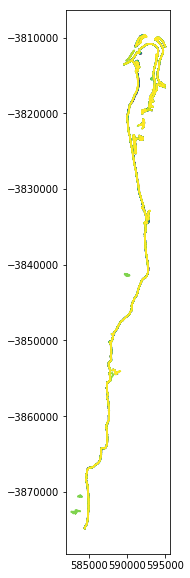

In [321]:
# Prepare attributes as input to contour extract
attribute_data = {'timeperiod': composite_ds.timeperiod.values.tolist(),
                  'obs_n': composite_ds.obs_n.values.tolist(),                  
                  'tide_m_ave': composite_ds.tide_heights.values.tolist(),
                  'tide_m_std': composite_ds.tide_m_std.values.tolist(),
                  'tide_m_min': composite_ds.tide_m_min.values.tolist(),
                  'tide_m_max': composite_ds.tide_m_max.values.tolist()}  
attribute_dtypes = {'timeperiod': 'str', 'obs_n': 'int', 'tide_m_ave': 'float:15.2', 
                    'tide_m_std': 'float:15.2', 'tide_m_min': 'float:15.2', 'tide_m_max': 'float:15.2'}

# Extract contours with custom attribute fields:
contours_gdf = SpatialTools.contour_extract(z_values=[index_threshold],
                                   ds_array=composite_ds[water_index],
                                   ds_crs=composite_ds.crs,
                                   ds_affine=composite_ds.geobox.transform,
                                   output_shp=f'output_data/{study_area}/{study_area}_{water_index}_{index_threshold}.shp',
                                   min_vertices=min_vertices,  
                                   attribute_data=attribute_data,
                                   attribute_dtypes=attribute_dtypes,
                                   verbose=False,                                   
                                   dim='timeperiod')

# Plot contours
import matplotlib.pyplot as plt
contours_gdf = contours_gdf.set_index('timeperiod')
fig, ax = plt.subplots(figsize=(10, 10))
contours_gdf.plot(ax=ax, cmap='viridis')
contours_gdf

[0.383, 0.4845]

## Compute change statistics

In [322]:
import fiona
from shapely.geometry import mapping
from shapely.ops import nearest_points
from shapely.geometry import Point, LineString, MultiPoint

# Set annual shoreline to use as a baseline
baseline_year = contours_gdf.index[0]
baseline_contour = contours_gdf.loc[baseline_year].geometry

# Set up output shapefile
schema = {'geometry': 'Point','properties': {'id': 'int'}}
output_file = f'output_data/{study_area}/{study_area}_{water_index}_{index_threshold}_statistics.shp'  #f'shoreline_dist/change_dist_{study_area}_{baseline_year}.shp'

with fiona.open(output_file, 'w', 'ESRI Shapefile', schema, crs=contours_gdf.crs) as output:
    
    # create points every 30 meters along the line
    for i, distance in enumerate(range(0, int(baseline_contour.length), 30)):
         point = baseline_contour.interpolate(distance)   
         output.write({'geometry': mapping(point), 'properties': {'id': i}}) 


In [323]:
# %load_ext line_profiler
# %%timeit -r 1 -n 1

def do_something(output_file):

    # Read points in as geopandas
    points_gdf = gpd.read_file(output_file)

    # Copy geometry to baseline point
    points_gdf['p_baseline'] = points_gdf.geometry

    # Get array of water index values for baseline time period 
    baseline_array = composite_ds.sel(timeperiod = baseline_year)[water_index]

    # Iterate through all comparison years in contour gdf
    for comp_year in contours_gdf.index.unique().values:

        print(comp_year)

        # Set comparison contour
        comp_contour = contours_gdf.loc[comp_year].geometry

        # Add P2 point
        points_gdf[f'p_{comp_year}'] = points_gdf.apply(lambda x: nearest_points(x.p_baseline, 
                                                                                 comp_contour)[1], axis=1)

        # Compute distance between baseline and comparison year
        points_gdf[f'{comp_year}'] = points_gdf.apply(lambda x: x.geometry.distance(comp_contour), axis=1)

        # Extract comparison array
        comp_array = composite_ds.sel(timeperiod = comp_year)[water_index]

        # Convert baseline and comparison year points to geoseries to allow easy access to x and y coords
        baseline_x_vals = gpd.GeoSeries(points_gdf.p_baseline).x
        baseline_y_vals = gpd.GeoSeries(points_gdf.p_baseline).y
        comp_x_vals = gpd.GeoSeries(points_gdf[f'p_{comp_year}']).x
        comp_y_vals = gpd.GeoSeries(points_gdf[f'p_{comp_year}']).y

        # Output lists 
        index_comp_p1 = []
        index_baseline_p2 = []

        # Extract water index values for chunks of points to reduce memory usage
        chunk_size = 500
        for i in range(0, len(points_gdf), chunk_size):

            index_comp_p1.append(np.diagonal(comp_array.interp(x=baseline_x_vals[i:i+chunk_size], 
                                                               y=baseline_y_vals[i:i+chunk_size]).values))

            index_baseline_p2.append(np.diagonal(baseline_array.interp(x=comp_x_vals[i:i+chunk_size], 
                                                                       y=comp_y_vals[i:i+chunk_size]).values))

        points_gdf['index_comp_p1'] = np.concatenate(index_comp_p1)
        points_gdf['index_baseline_p2'] = np.concatenate(index_baseline_p2)

        # Compute directionality of change (negative = erosion, positive = accretion)    
        points_gdf['loss_gain'] = (points_gdf.index_baseline_p2 > points_gdf.index_comp_p1).astype(int).replace(to_replace=0, value=-1)
        points_gdf[f'{comp_year}'] = points_gdf[f'{comp_year}'] * points_gdf.loss_gain

    # Keep required columns
    points_gdf = points_gdf[['geometry'] + contours_gdf.index.unique().values.tolist()]
    points_gdf = points_gdf.round(2)

    # Compute change rates
    points_gdf[['rate_change', 'rate_sig', 'outliers']] = points_gdf.apply(lambda x: change_regress(x, std_dev=3), axis=1)

    # Set insignificant rates to nan
    points_gdf.loc[points_gdf.rate_sig > 0.05, 'rate_change'] = np.nan

    # Export to file
    points_gdf.crs = str(composite_ds.crs)
    points_gdf.to_file(output_file)
    
do_something(output_file)

# Run profiler
# %lprun -f do_something do_something(output_file)

1987-01-01
1988-01-01
1989-01-01
1990-01-01
1991-01-01
1992-01-01
1993-01-01
1994-01-01
1995-01-01
1996-01-01
1997-01-01
1998-01-01
1999-01-01
2000-01-01
2001-01-01
2002-01-01
2003-01-01
2004-01-01
2005-01-01
2006-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01


/g/data/v10/public/modules/dea-env/20190208/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [94]:
import scipy.ndimage
chunk_size = 500
scipy.ndimage.map_coordinates(comp_array, np.vstack((baseline_x_vals[i:i+chunk_size],baseline_y_vals[i:i+chunk_size])))

array([], dtype=float64)

In [231]:
comp_array = composite_ds.sel(timeperiod = comp_year)[water_index]
baseline_array = composite_ds.sel(timeperiod = baseline_year)[water_index]
comp_array

<xarray.DataArray 'mndwi' (y: 2280, x: 6518)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-0.246379, -0.185195, -0.268084, ..., -0.578687, -0.565326, -0.546014],
       [-0.279732, -0.228658, -0.308732, ..., -0.579853, -0.581672, -0.555463],
       [-0.244009, -0.299971, -0.36641 , ..., -0.583469, -0.578002, -0.561792]])
Coordinates:
  * x           (x) float64 6.955e+05 6.956e+05 6.956e+05 ... 8.91e+05 8.91e+05
  * y           (y) float64 -1.327e+06 -1.327e+06 ... -1.396e+06 -1.396e+06
    timeperiod  <U10 '2018-01-01'

In [232]:
xx = [(~composite_ds.geobox.transform * (x, y))[0] for i, (x, y) in pd.concat([baseline_x_vals[0:50], baseline_y_vals[0:50]], axis=1).iterrows()]
yy = [(~composite_ds.geobox.transform * (x, y))[1] for i, (x, y) in pd.concat([baseline_x_vals[0:50], baseline_y_vals[0:50]], axis=1).iterrows()]
scipy.ndimage.map_coordinates(comp_array, np.vstack((xx, yy)))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [242]:
test3 = scipy.ndimage.map_coordinates(baseline_array, np.vstack((yy, xx)), order=0)

In [234]:
test1 = np.diagonal(baseline_array.interp(x=baseline_x_vals[0:50], 
                              y=baseline_y_vals[0:50]).values)

In [235]:
test2 = baseline_array.values[[int(i) for i in yy], [int(i) for i in xx]]

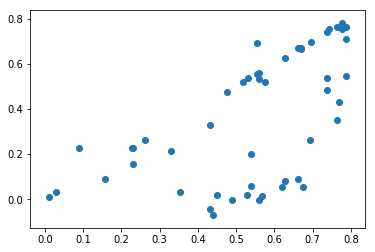

In [243]:
plt.scatter(test2, test3)

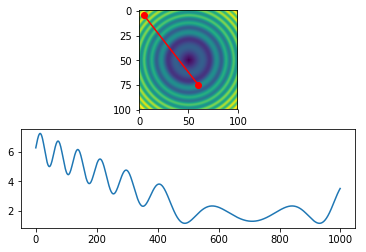

In [151]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

#-- Generate some data...
x, y = np.mgrid[-5:5:0.1, -5:5:0.1]
z = np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2)

#-- Extract the line...
# Make a line with "num" points...
x0, y0 = 5, 4.5 # These are in _pixel_ coordinates!!
x1, y1 = 60, 75
num = 1000
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

# Extract the values along the line, using cubic interpolation
zi = scipy.ndimage.map_coordinates(z, np.vstack((x,y)))

#-- Plot...
fig, axes = plt.subplots(nrows=2)
axes[0].imshow(z)
axes[0].plot([x0, x1], [y0, y1], 'ro-')
axes[0].axis('image')

axes[1].plot(zi)

plt.show()

In [164]:
z.shape

(100, 100)

In [167]:
np.vstack((xx, yy))

array([[3422.5       , 3421.71088901, 3420.89554135, 3420.07367211,
        3419.25070542, 3418.42383208, 3417.64512288, 3416.84965026,
        3416.0793529 , 3415.29980308, 3414.4727569 , 3413.69211288,
        3412.95836596, 3412.20385437, 3411.37494483, 3410.54501302,
        3409.72765912, 3408.92907358, 3408.14679439, 3407.40532716,
        3406.57249546, 3405.81482222, 3405.01362641, 3404.2060208 ,
        3403.48940536, 3402.6830538 , 3401.87360272, 3401.05202472,
        3400.22026608, 3399.38801162, 3398.55999575, 3397.73756377,
        3396.96720725, 3396.16985433, 3395.34951972, 3394.51682551,
        3393.68765056, 3392.85988189, 3392.03277155, 3391.2087423 ,
        3390.41714961, 3389.59404412, 3388.76445507, 3387.93210171,
        3387.1008303 , 3386.28144385, 3385.48711386, 3384.6545947 ,
        3383.97850599, 3383.28840357],
       [1042.90740747, 1042.63954876, 1042.65453055, 1042.79110883,
        1042.88506076, 1042.87311805, 1043.16986107, 1043.41691973,
        1